In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import random
import os

In [2]:
# read the data
df = pd.read_csv("/Users/judepereira/Downloads/ieee-fraud-detection/train_transaction.csv")

In [3]:
# derive “day” from TransactionDT
df["day"] = (df["TransactionDT"] // (3600 * 24)).astype(int)

# derive card activation date from TransactionDT
df['D1new'] = (df['TransactionDT'] // (60*60*24)) - df['D1'] + 2000

# drop TransactionDT as it is no longer needed
df.drop("TransactionDT", axis=1, inplace=True)

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [5]:
SEED = 42
seed_everything(SEED)

In [6]:
# compute missing % for all columns
nulls = df.isna().mean() * 100

# find columns with more than 80% missing values
cols_80 = nulls[nulls >= 80].index.tolist()

# and drop them!
df.drop(columns=cols_80, inplace=True)

In [7]:
from sklearn.impute import SimpleImputer

# numeric imputation (median) – exclude the target “isFraud”
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove("isFraud")

# among num_cols, find columns with nans that need to be imputed
nan_cols = [c for c in num_cols if df[c].isna().any()]

# exclude the categorical columns card1, card2, card3, card5, addr1, addr2
cat_cols = ["card1", "card2", "card3", "card5", "addr1", "addr2"]
nan_cols = [c for c in nan_cols if c not in cat_cols]

imputer = SimpleImputer(strategy="median")
df[nan_cols] = imputer.fit_transform(df[nan_cols])

In [8]:
# for remaining categoricals, one‐hot encode small‐cardinaliy ones
cat_cols_rem = df.select_dtypes(include=["object"]).columns.tolist()

# include the cat_cols that were excluded earlier
cat_cols_rem.extend(cat_cols)

# extract high cardinality categorical columns
high_card_cols = [c for c in cat_cols_rem if df[c].nunique() > 10]

# e.g. “ProductCD”, “MISSING” placeholders, etc.
for c in cat_cols_rem:
    n_uniq = df[c].nunique()
    print(f"Column: {c}, Unique values: {n_uniq}")
    if n_uniq <= 10:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=True)
        df = pd.concat([df.drop(c, axis=1), dummies], axis=1)

Column: ProductCD, Unique values: 5
Column: card4, Unique values: 4
Column: card6, Unique values: 4
Column: P_emaildomain, Unique values: 59
Column: R_emaildomain, Unique values: 60
Column: M1, Unique values: 2
Column: M2, Unique values: 2
Column: M3, Unique values: 2
Column: M4, Unique values: 3
Column: M5, Unique values: 2
Column: M6, Unique values: 2
Column: M7, Unique values: 2
Column: M8, Unique values: 2
Column: M9, Unique values: 2
Column: card1, Unique values: 13553
Column: card2, Unique values: 500
Column: card3, Unique values: 114
Column: card5, Unique values: 119
Column: addr1, Unique values: 332
Column: addr2, Unique values: 74


In [9]:
print(f"High cardinality categorical columns: {high_card_cols}")

High cardinality categorical columns: ['P_emaildomain', 'R_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1', 'addr2']


In [10]:
df.head()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,M1_T,M2_T,M3_T,M4_M1,M4_M2,M5_T,M6_T,M7_T,M8_T,M9_T
0,2987000,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,True,True,True,False,True,False,True,False,False,False
1,2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,...,False,False,False,False,False,True,True,False,False,False
2,2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,True,True,True,False,False,False,False,False,False,False
3,2987003,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,...,False,False,False,False,False,True,False,False,False,False
4,2987004,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,...,False,False,False,False,False,False,False,False,False,False


In [11]:
# find all bool columns in df
bool_cols = df.select_dtypes(include="bool").columns

# cast them to int (True→1, False→0)
df[bool_cols] = df[bool_cols].astype(int)

In [12]:
df.head()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,M1_T,M2_T,M3_T,M4_M1,M4_M2,M5_T,M6_T,M7_T,M8_T,M9_T
0,2987000,0,68.5,13926,NaN,150.0,142.0,315.0,87.0,19.0,...,1,1,1,0,1,0,1,0,0,0
1,2987001,0,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,...,0,0,0,0,0,1,1,0,0,0
2,2987002,0,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,...,1,1,1,0,0,0,0,0,0,0
3,2987003,0,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,...,0,0,0,0,0,1,0,0,0,0
4,2987004,0,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# label encode high cardinality categorical columns
from sklearn.preprocessing import LabelEncoder

# Store encoders for later inference
encoders = {}
for col in high_card_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

In [14]:
df.head()

,TransactionID,isFraud,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,...,M1_T,M2_T,M3_T,M4_M1,M4_M2,M5_T,M6_T,M7_T,M8_T,M9_T
0,2987000,0,68.5,3417,500,42,38,166,65,19.0,...,1,1,1,0,1,0,1,0,0,0
1,2987001,0,29.0,7922,303,42,2,173,65,8.0,...,0,0,0,0,0,1,1,0,0,0
2,2987002,0,59.0,9383,389,42,58,178,65,287.0,...,1,1,1,0,0,0,0,0,0,0
3,2987003,0,50.0,6991,466,42,14,282,65,8.0,...,0,0,0,0,0,1,0,0,0,0
4,2987004,0,50.0,9262,413,42,2,241,65,8.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# density model & scoring
from scipy.stats import multivariate_normal

# splitting & evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_recall_fscore_support, roc_auc_score
)

In [16]:
# all non‐fraud examples
df_norm = df[df.isFraud == 0].copy()
# all fraud examples
df_fraud = df[df.isFraud == 1].copy()

# hold out 20% of normals for CV
norm_train, norm_cv = train_test_split(
    df_norm, test_size=0.2, random_state=42
)

# CV set = held‐out normals + all frauds
df_cv = pd.concat([norm_cv, df_fraud], axis=0)
y_cv  = df_cv["isFraud"].values

# drop labels for modeling
X_train = norm_train.drop("isFraud", axis=1)
X_cv    = df_cv.drop("isFraud", axis=1)

print("→ Training on normals only:", X_train.shape)
print("→ CV set (normals+fraud):", X_cv.shape)

→ Training on normals only: (455901, 347)
→ CV set (normals+fraud): (134639, 347)


In [17]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Identify one-hot columns (all values are 0 or 1)
one_hot_cols = [col for col in X_train.columns if set(X_train[col].unique()) <= {0, 1}]
non_one_hot_cols = [col for col in X_train.columns if col not in one_hot_cols]


In [18]:
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_cv_scaled    = X_cv.copy()

X_train_scaled[non_one_hot_cols] = scaler.fit_transform(X_train[non_one_hot_cols])
X_cv_scaled[non_one_hot_cols]    = scaler.transform(X_cv[non_one_hot_cols])


In [19]:
X_train = X_train_scaled.values
X_cv    = X_cv_scaled.values

In [20]:
# fit a multivariate Gaussian to the normals
from sklearn.covariance import EmpiricalCovariance
from scipy.stats import multivariate_normal

# fit covariance on your normal-only training set
ec = EmpiricalCovariance().fit(X_train)

mu  = ec.location_       # shape (377,)
cov = ec.covariance_     # shape (377, 377)

rv = multivariate_normal(mean=mu, cov=cov, allow_singular=True)

# log‐pdf on train vs CV
train_ll = rv.logpdf(X_train)
cv_ll    = rv.logpdf(X_cv)

In [21]:
# pick ε as the α‐percentile of train log‐likelihoods
# e.g. α = 5 means flag ~5% of normals as anomalies in‐sample
α = 30  
epsilon = np.percentile(train_ll, α)

print(f"Chosen ε = {epsilon:.2f} (the {α}th percentile of train log‐likelihood)")

Chosen ε = 150.17 (the 30th percentile of train log‐likelihood)


In [22]:
# anomaly if log‐likelihood < ε
y_pred = (cv_ll < epsilon).astype(int)

In [23]:
cm = confusion_matrix(y_cv, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_cv, y_pred, pos_label=1, average='binary'
)
#auc = roc_auc_score(y_cv, -cv_ll)  # higher “anomaly score” = more likely fraud

print("Confusion Matrix (CV):")
print(f"             Pred 0    Pred 1")
print(f"Actual 0       {tn:5d}      {fp:5d}")
print(f"Actual 1       {fn:5d}      {tp:5d}\n")

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
#print(f"AUC (using –log‐likelihood): {auc:.3f}")

Confusion Matrix (CV):
             Pred 0    Pred 1
Actual 0       79493      34483
Actual 1        6321      14342

Precision: 0.294
Recall:    0.694
F1-score:  0.413


In [24]:
# compute raw anomaly scores
scores = -cv_ll

# find any +inf (which come from cv_ll == -inf)
inf_mask = np.isinf(scores)
if inf_mask.any():
    # choose a value just above the max finite score
    max_finite = scores[~inf_mask].max()
    scores[inf_mask] = max_finite + 1e-6

# now compute AUC
auc = roc_auc_score(y_cv, scores)
print(f"AUC (using –log‐likelihood, clipped): {auc:.3f}")

AUC (using –log‐likelihood, clipped): 0.760


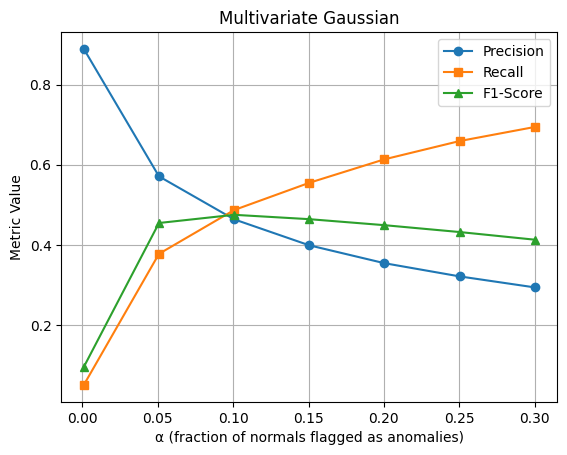

In [25]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt

# Sweep alphas (fraction of normals flagged)
alphas = np.linspace(0.001, 0.3, 7)  # from 1% to 10%
precisions, recalls, f1s = [], [], []

for alpha in alphas:
    # set threshold at the alpha-percentile
    epsilon = np.percentile(train_ll, alpha * 100)
    y_pred = (cv_ll < epsilon).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_cv, y_pred, pos_label=1, average='binary'
    )
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# Plot all three metrics against alpha
plt.figure()
plt.plot(alphas, precisions, marker='o', label='Precision')
plt.plot(alphas, recalls,    marker='s', label='Recall')
plt.plot(alphas, f1s,        marker='^', label='F1-Score')
plt.xlabel('α (fraction of normals flagged as anomalies)')
plt.ylabel('Metric Value')
plt.title('Multivariate Gaussian')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.mixture import GaussianMixture
#gmm = GaussianMixture(n_components=2, covariance_type="full", random_state=42)

gmm = GaussianMixture(
    n_components=3,
    covariance_type="full",   # or "tied", "spherical"
    reg_covar=1e-5,           # adds 0.001 to diagonal of each covariance
    #init_params="kmeans",
    random_state=42,
    #max_iter=200
)
gmm.fit(X_train)
train_ll = gmm.score_samples(X_train)
cv_ll    = gmm.score_samples(X_cv)

In [27]:
# pick ε as the α‐percentile of train log‐likelihoods
# e.g. α = 5 means flag ~5% of normals as anomalies in‐sample
α = 30  
epsilon = np.percentile(train_ll, α)

print(f"Chosen ε = {epsilon:.2f} (the {α}th percentile of train log‐likelihood)")

Chosen ε = 177.59 (the 30th percentile of train log‐likelihood)


In [28]:
# anomaly if log‐likelihood < ε
y_pred = (cv_ll < epsilon).astype(int)

In [29]:
cm = confusion_matrix(y_cv, y_pred, labels=[0,1])
tn, fp, fn, tp = cm.ravel()
precision, recall, f1, _ = precision_recall_fscore_support(
    y_cv, y_pred, pos_label=1, average='binary'
)
#auc = roc_auc_score(y_cv, -cv_ll)  # higher “anomaly score” = more likely fraud

print("Confusion Matrix (CV):")
print(f"             Pred 0    Pred 1")
print(f"Actual 0       {tn:5d}      {fp:5d}")
print(f"Actual 1       {fn:5d}      {tp:5d}\n")

print(f"Precision: {precision:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"F1-score:  {f1:.3f}")
#print(f"AUC (using –log‐likelihood): {auc:.3f}")

Confusion Matrix (CV):
             Pred 0    Pred 1
Actual 0       79468      34508
Actual 1        6282      14381

Precision: 0.294
Recall:    0.696
F1-score:  0.414


In [30]:
# compute raw anomaly scores
scores = -cv_ll

# find any +inf (which come from cv_ll == -inf)
inf_mask = np.isinf(scores)
if inf_mask.any():
    # choose a value just above the max finite score
    max_finite = scores[~inf_mask].max()
    scores[inf_mask] = max_finite + 1e-6

# now compute AUC
auc = roc_auc_score(y_cv, scores)
print(f"AUC (using –log‐likelihood, clipped): {auc:.3f}")

AUC (using –log‐likelihood, clipped): 0.762


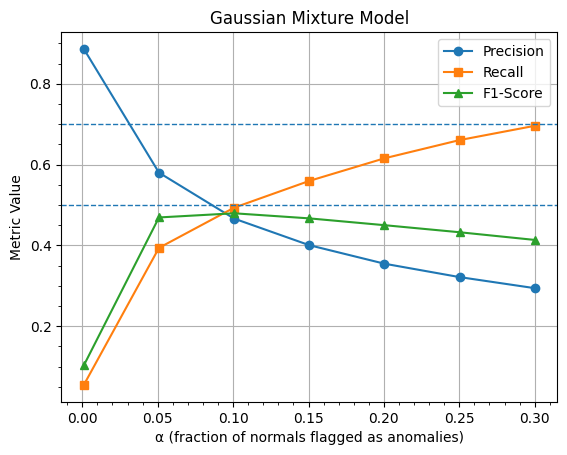

In [31]:
# Sweep alphas (fraction of normals flagged)
alphas = np.linspace(0.001, 0.3, 7)  # from 1% to 10%
precisions, recalls, f1s = [], [], []

for alpha in alphas:
    # set threshold at the alpha-percentile
    epsilon = np.percentile(train_ll, alpha * 100)
    y_pred = (cv_ll < epsilon).astype(int)

    p, r, f1, _ = precision_recall_fscore_support(
        y_cv, y_pred, pos_label=1, average='binary'
    )
    precisions.append(p)
    recalls.append(r)
    f1s.append(f1)

# Plot all three metrics against alpha
plt.figure()
plt.plot(alphas, precisions, marker='o', label='Precision')
plt.plot(alphas, recalls,    marker='s', label='Recall')
plt.plot(alphas, f1s,        marker='^', label='F1-Score')
# Add horizontal line at y=0.7
plt.axhline(y=0.5, linestyle='--', linewidth=1)
plt.axhline(y=0.7, linestyle='--', linewidth=1)
plt.xlabel('α (fraction of normals flagged as anomalies)')
plt.ylabel('Metric Value')
plt.title('Gaussian Mixture Model')
plt.legend()
plt.minorticks_on()
plt.grid(True)
#plt.grid(which='minor', color='r', linestyle='-', alpha=0.2)
plt.show()